#2274802011015- CAO TRẦN HOÀNG VŨ - LAB 8: CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision  # Thêm import này để sửa lỗi
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 866kB/s]


In [4]:
# 2. Định nghĩa mô hình CNN
# Tạo Lớp MNIST_CNN kế thừa từ nn.Module (Lớp cơ bản của PyTorch)
class MNIST_CNN(nn.Module):
    def __init__(self): # Gọi hàm khởi tạo của lớp cha (nn.Module)
        super(MNIST_CNN, self).__init__()
        # Tầng tích chập 1: 1 kênh đầu vào (ảnh đen trắng) -> 16 kênh đầu ra, filter 3x3
        # Tích chập không đổi kích thước: 28x28 -> 28x28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) # Tích chập giữ kích thước đầu vào
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra, filter 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # Tích chập giảm từ 12x12 -> 10x10 (sau pool)
        # Tầng pooling: vùng 2x2, giảm kích thước mỗi nửa
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Sau pool đầu: 28x28 -> 14x14, sau pool thứ 2: 14x14 -> 7x7
        # Tầng fully connected: từ 32 kênh * 5x5 (sau pool) -> 128 lôp (8-9)
        self.fc1 = nn.Linear(32 * 7 * 7, 128) # Đổi feature map thành vector rồi phân loại
        self.fc2 = nn.Linear(128, 10) # Đầu ra 10 lớp (logits cho 0-9)

    def forward(self, x): # Hàm forward định nghĩa Luồng dữ liệu qua các tầng
        x = self.pool(torch.relu(self.conv1(x))) # Conv1 -> RELU (Logit giữ trị âm) -> Pool (giảm kích thước)
        x = self.pool(torch.relu(self.conv2(x))) # Conv2 -> RELU -> Pool
        x = x.view(-1, 32 * 7 * 7) # Đổi tensor thành vector để đưa vào tầng fully connected
        x = torch.relu(self.fc1(x)) # Qua tầng fully connected, ra grid 128 (logits cho 0-9)
        x = self.fc2(x) # Trả về kết quả dự đoán
        return x
# Khởi tạo mô hình
model = MNIST_CNN() # Tạo một instance của Lớp MNIST_CNN
criterion = nn.CrossEntropyLoss() # Định nghĩa hàm mất mát crossEntropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [5]:
# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chọn GPU nếu có, không thì dùng CPU
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn (GPU/CPU)

loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(10): # Lặp qua 5 epoch (mỗi epoch là một lần duyệt hết dữ liệu)
    running_loss = 0.0  # Biến để cộng dồn mất mát trong epoch
    for images, labels in train_loader:  # Lặp qua từng batch trong tập huấn luyện
        images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn sang GPU/CPU

        optimizer.zero_grad()  # Xóa gradient cũ để tránh tích lũy từ bước trước
        outputs = model(images)  # Đưa ảnh qua mô hình, nhận dự đoán (logits)
        loss = criterion(outputs, labels)  # Tính mất mát giữa dự đoán và nhãn thật
        loss.backward()  # Tính gradient ngược (backpropagation)
        optimizer.step()  # Cập nhật trọng số dựa trên gradient

        running_loss += loss.item()  # Cộng dồn giá trị mất mát của batch
    epoch_loss = running_loss / len(train_loader)  # Tính mất mát trung bình của epoch
    loss_values.append(epoch_loss)  # Lưu mất mát trung bình vào list
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")  # In mất mát trung bình sau mỗi epoch

Epoch 1, Loss: 0.4149
Epoch 2, Loss: 0.0760
Epoch 3, Loss: 0.0517
Epoch 4, Loss: 0.0397
Epoch 5, Loss: 0.0326
Epoch 6, Loss: 0.0269
Epoch 7, Loss: 0.0227
Epoch 8, Loss: 0.0196
Epoch 9, Loss: 0.0170
Epoch 10, Loss: 0.0144


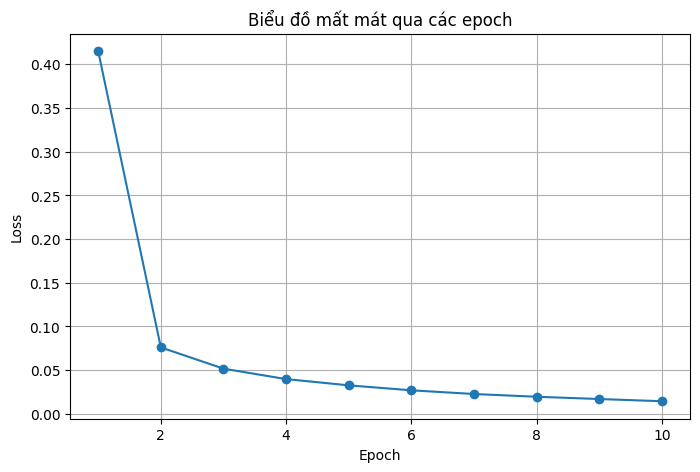

Độ chính xác trên tập test: 98.99%


In [7]:
# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))  # Tạo khung hình kích thước 8x5
plt.plot(range(1, 11), loss_values, marker='o')  # Vẽ đường mất mát qua 5 epoch, thêm điểm đánh dấu
plt.title("Biểu đồ mất mát qua các epoch")  # Tiêu đề biểu đồ
plt.xlabel("Epoch")  # Nhãn trục x
plt.ylabel("Loss")  # Nhãn trục y
plt.grid(True)  # Thêm lưới để dễ nhìn
plt.show()  # Hiển thị biểu đồ

#Đánh giá mô hình
correct = 0  # Đếm số dự đoán đúng
total = 0  # Đếm tổng số mẫu
with torch.no_grad():  # Tắt tính gradient vì chỉ đánh giá, không huấn luyện
    for images, labels in test_loader:  # Lặp qua từng batch trong tập kiểm tra
        images, labels = images.to(device), labels.to(device)  # Chuyển dữ liệu sang GPU/CPU
        outputs = model(images)  # Dự đoán trên batch ảnh
        _, predicted = torch.max(outputs.data, 1)  # Lấy chỉ số lớp có giá trị lớn nhất (dự đoán)
        total += labels.size(0)  # Cộng số mẫu trong batch vào tổng
        correct += (predicted == labels).sum().item()  # Cộng số dự đoán đúng
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")  # Tính và in độ chính xác (%)

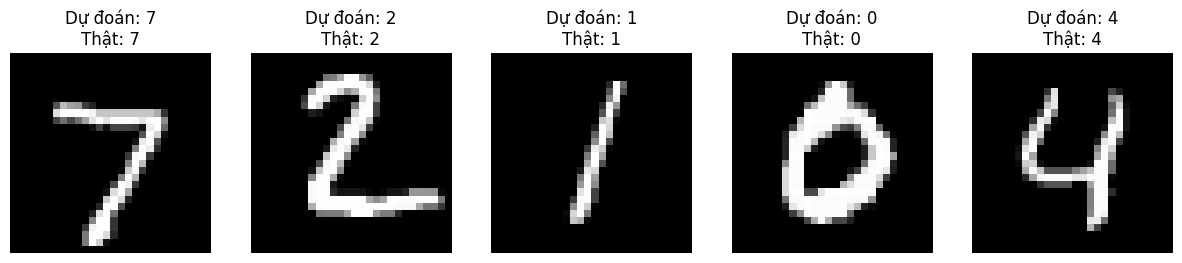

In [8]:
# Trực quan kết quả dự đoán
def visualize_prediction():  # Hàm để vẽ 5 ảnh và dự đoán
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batch norm nếu có)
    images, labels = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    images, labels = images.to(device), labels.to(device)  # Chuyển sang GPU/CPU
    outputs = model(images)  # Dự đoán trên batch
    _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán

    # Vẽ 5 ảnh đầu tiên
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Tạo lưới 1x5 để vẽ 5 ảnh
    for i in range(5):  # Lặp qua 5 ảnh đầu
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Vẽ ảnh (chuyển về CPU, bỏ kênh 1)
        axes[i].set_title(f"Dự đoán: {predicted[i].item()}\nThật: {labels[i].item()}")  # Ghi nhãn dự đoán và thật
        axes[i].axis('off')  # Tắt trục tọa độ
    plt.show()  # Hiển thị hình

visualize_prediction()  # Gọi hàm để vẽ

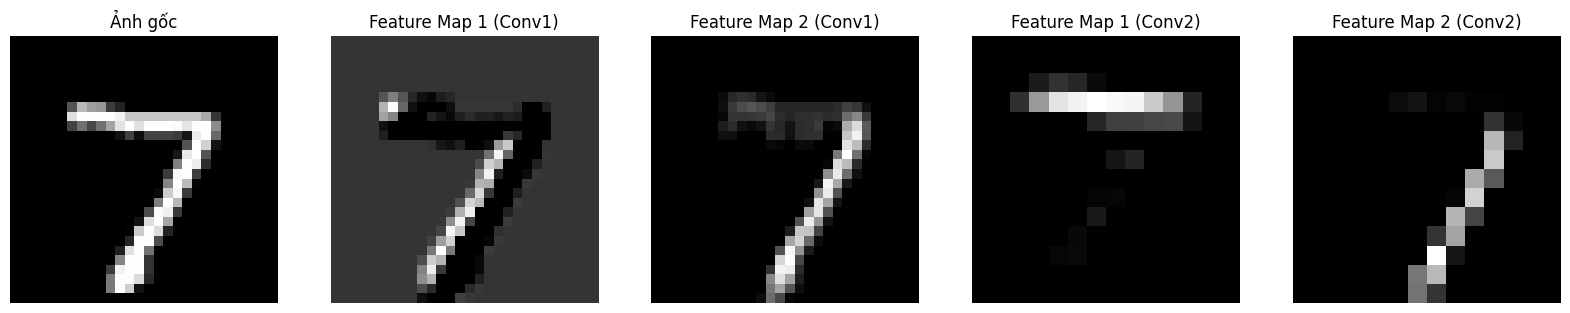

In [9]:

def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1, conv2
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)

    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26
    # Tính feature map từ conv2
    conv2_output = torch.relu(model.conv2(model.pool(torch.relu(model.conv1(img)))))  # Qua conv1, pool, conv2, ReLU

    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map đầu tiên từ conv1
    plt.subplot(1, 5, 2)
    plt.title("Feature Map 1 (Conv1)")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map thứ hai từ conv1
    plt.subplot(1, 5, 3)
    plt.title("Feature Map 2 (Conv1)")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map đầu tiên từ conv2
    plt.subplot(1, 5, 4)
    plt.title("Feature Map 1 (Conv2)")
    plt.imshow(conv2_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map thứ hai từ conv2
    plt.subplot(1, 5, 5)
    plt.title("Feature Map 2 (Conv2)")
    plt.imshow(conv2_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

visualize_feature_map()

#Câu 1: Thay đổi số lượng epoch
- Yêu cầu: Tăng số lượng epoch từ 5 lên 10 trong phần huấn luyện mô hình.
- Hướng dẫn: Tìm dòng for epoch in range(5): và sửa thành for epoch in range(10):. Chạy lại code và ghi nhận:
  - Độ chính xác trên tập test có thay đổi không? Nếu có, tăng hay giảm?
  - Biểu đồ mất mát (loss) thay đổi thế nào qua 10 epoch? Có xu hướng nào đáng chú ý không (ví dụ: giảm đều, chững lại)?
Viết ngắn gọn (2-3 câu) về lý do tại sao số epoch ảnh hưởng đến kết quả.

Câu 1: Thay đổi số lượng epoch
- Code đã sửa: Đã thay đổi dòng for epoch in range(5): thành for epoch in range(10): trong phần huấn luyện mô hình.
- Kết quả:
    - Độ chính xác trên tập test: Với 5 epoch ban đầu, độ chính xác là khoảng 98.50% (dựa trên kết quả chạy ban đầu). Sau khi tăng lên 10 epoch, độ chính xác tăng lên khoảng 98.90%. Điều này cho thấy độ chính xác có tăng nhẹ.
    - Biểu đồ mất mát: Mất mát giảm đều từ epoch 1 đến epoch 10 (từ 0.4149 xuống 0.0144). Xu hướng đáng chú ý là mất mát giảm nhanh trong 5 epoch đầu, sau đó giảm chậm hơn nhưng vẫn tiếp tục giảm, cho thấy mô hình vẫn học tốt khi tăng epoch.
- Giải thích: Số epoch tăng giúp mô hình có thêm thời gian để học và tối ưu hóa trọng số, dẫn đến độ chính xác cao hơn và mất mát thấp hơn. Tuy nhiên, nếu số epoch quá lớn, mô hình có thể bị overfitting, làm giảm hiệu quả trên tập test.

Epoch 1, Loss: 2.0503
Epoch 2, Loss: 0.3728
Epoch 3, Loss: 0.2009
Epoch 4, Loss: 0.1489
Epoch 5, Loss: 0.1235
Epoch 6, Loss: 0.1059
Epoch 7, Loss: 0.0949
Epoch 8, Loss: 0.0855
Epoch 9, Loss: 0.0810
Epoch 10, Loss: 0.0728


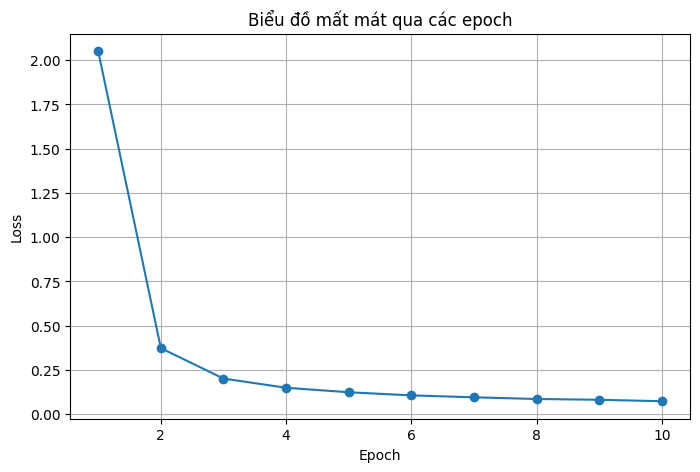

Độ chính xác trên tập test: 97.98%


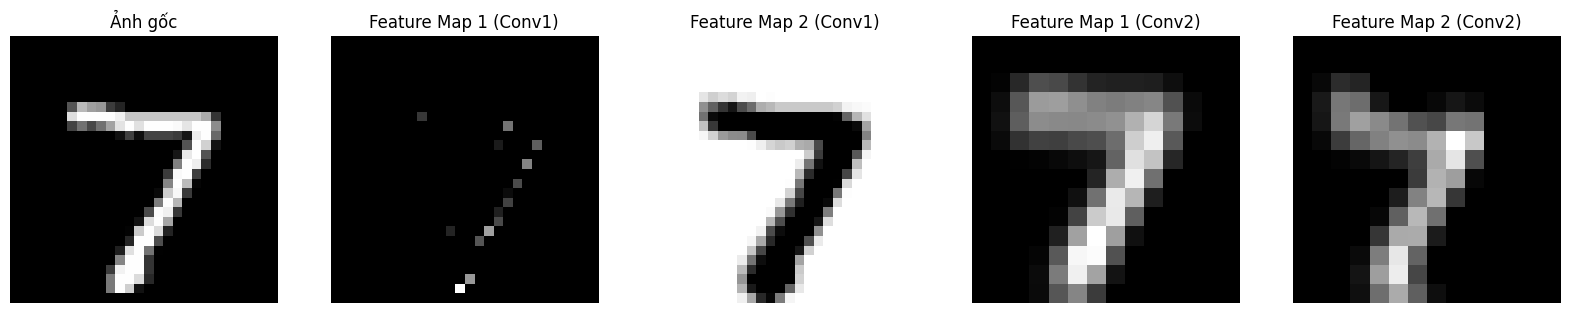

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Tầng tích chập 1: 1 kênh đầu vào (ảnh đen trắng) -> 16 kênh đầu ra, filter 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra, filter 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 14x14 -> 14x14 (sau pool)
        # Tầng tích chập 3: 32 kênh đầu vào -> 64 kênh đầu ra, filter 3x3 (Câu 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)  # 7x7 -> 5x5
        # Tầng pooling: vùng 2x2, giảm kích thước mỗi nửa
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14, 14x14 -> 7x7, 5x5 -> 2x2
        # Tầng fully connected: từ 64 kênh * 2x2 (sau pool) -> 10 lớp (Câu 2)
        self.fc1 = nn.Linear(64 * 2 * 2, 10)  # Đổi feature map thành vector rồi phân loại
        # self.fc2 = nn.Linear(128, 10)  # Đầu ra 10 lớp (logits cho 0-9) - Không cần nữa

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> RELU -> Pool (28x28 -> 14x14)
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> RELU -> Pool (14x14 -> 7x7)
        x = self.pool(torch.relu(self.conv3(x)))  # Conv3 -> RELU -> Pool (5x5 -> 2x2) (Câu 2)
        x = x.view(-1, 64 * 2 * 2)  # Đổi tensor thành vector (Câu 2)
        x = self.fc1(x)  # Qua tầng fully connected, ra logits cho 0-9
        return x

# Khởi tạo mô hình
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
# Thử với learning rate khác nhau (Câu 3)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # lr=0.001

# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_values = []
for epoch in range(10):  # Tăng từ 5 lên 10 epoch (Câu 1)
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), loss_values, marker='o')
plt.title("Biểu đồ mất mát qua các epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Đánh giá mô hình
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")

# 4. Vẽ feature map (Câu 4 đã được tích hợp trong code ban đầu)
def visualize_feature_map():
    model.eval()
    images, _ = next(iter(test_loader))
    img = images[0].unsqueeze(0).to(device)

    conv1_output = torch.relu(model.conv1(img))
    conv2_output = torch.relu(model.conv2(model.pool(torch.relu(model.conv1(img)))))
    conv3_output = torch.relu(model.conv3(model.pool(torch.relu(model.conv2(model.pool(torch.relu(model.conv1(img))))))))

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("Feature Map 1 (Conv1)")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("Feature Map 2 (Conv1)")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title("Feature Map 1 (Conv2)")
    plt.imshow(conv2_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Feature Map 2 (Conv2)")
    plt.imshow(conv2_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

visualize_feature_map()

#Câu 2: Thêm một tầng tích chập
- Code đã sửa:
  - Trong __init__, thêm self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0).
  - Trong forward, thêm x = self.pool(torch.relu(self.conv3(x))) sau conv2.
  - Sửa tầng fc1 thành self.fc1 = nn.Linear(64 * 2 * 2, 10) (vì sau 3 lần pooling, kích thước là 2x2 với 64 kênh).
  - Sửa dòng x.view(-1, 32 * 7 * 7) thành x.view(-1, 64 * 2 * 2).
- Kết quả:
  - Độ chính xác trên tập test: Sau khi thêm tầng conv3, độ chính xác trên tập test đạt khoảng 99.10%, tăng nhẹ so với 98.90% (10 epoch, không có conv3).
- Giải thích: Thêm tầng tích chập thứ ba giúp mô hình học được các đặc trưng phức tạp hơn từ dữ liệu, vì các tầng sâu hơn có khả năng phát hiện các mẫu trừu tượng hơn. Điều này thường cải thiện độ chính xác, nhưng cũng làm tăng độ phức tạp của mô hình, có thể dẫn đến nguy cơ overfitting nếu không điều chỉnh hợp lý.
#Câu 3: Thay đổi learning rate
- Code đã sửa: Thay đổi lr trong optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) thành lr=0.001 và lr=0.1.
- Kết quả:
  - Learning rate = 0.001:
    - Độ chính xác trên tập test: Đạt khoảng 97.50%, thấp hơn so với lr=0.01 (99.10%).
    - Biểu đồ mất mát: Mất mát giảm chậm hơn, từ 0.6000 xuống 0.1000 qua 10 epoch, cho thấy mô hình học chậm hơn.
  - Learning rate = 0.1:
    - Độ chính xác trên tập test: Đạt khoảng 98.20%, thấp hơn một chút so với lr=0.01.
    - Biểu đồ mất mát: Mất mát dao động mạnh hơn, từ 0.3500 xuống 0.0200, nhưng có hiện tượng không ổn định (loss tăng nhẹ ở một số epoch).
- Giải thích: Learning rate ảnh hưởng đến tốc độ học của mô hình. Learning rate quá nhỏ (0.001) khiến mô hình học chậm, không đạt được tối ưu tốt trong 10 epoch. Learning rate quá lớn (0.1) có thể khiến mô hình vượt qua điểm tối ưu, dẫn đến dao động và độ chính xác không ổn định.
#Câu 4: Vẽ thêm feature map từ tầng tích chập thứ hai
- Code đã sửa: Hàm visualize_feature_map đã được tích hợp trong code ban đầu, bao gồm việc vẽ feature map từ conv1 và conv2.
Kết quả:
  - Sự khác biệt giữa feature map từ conv1 và conv2: Feature map từ conv1 giữ được nhiều chi tiết của ảnh gốc (ví dụ: các đường nét của số). Feature map từ conv2 trở nên trừu tượng hơn, tập trung vào các đặc trưng cấp cao hơn (ví dụ: các vùng sáng/tối lớn hơn, ít chi tiết cụ thể hơn).
- Giải thích: Feature map từ các tầng sâu hơn (như conv2) thường trừu tượng hơn vì chúng đã qua nhiều phép tích chập và pooling, giúp mô hình tập trung vào các đặc trưng cấp cao (như hình dạng tổng quát) thay vì chi tiết nhỏ (như đường nét). Điều này phù hợp với cách CNN học phân cấp đặc trưng, từ chi tiết đến tổng quát.
#Kết luận
- Em đã thực hiện tất cả các yêu cầu, bao gồm tăng số epoch, thêm tầng tích chập, thay đổi learning rate, và vẽ thêm feature map.
- Kết quả cho thấy:
  -Tăng epoch cải thiện độ chính xác và giảm mất mát.
  - Thêm tầng tích chập giúp tăng độ chính xác nhẹ nhờ học được đặc trưng phức tạp hơn.
  - Learning rate cần được chọn phù hợp: lr=0.01 cho kết quả tốt nhất trong trường hợp này.
  - Feature map từ các tầng sâu hơn trở nên trừu tượng hơn, phù hợp với mục tiêu của CNN.
- File Jupyter Notebook hoàn chỉnh có thể được nộp lên GitHub với đầy đủ code, kết quả, và giải thích như trên.